In [6]:
import pymc3 as pm
import pandas as pd
import matplotlib 

%matplotlib inline

Here, we make a few modeeling choices.

1. We care only about the `normalized_measurement` column, and so we choose the t-distribution to model it, as we don't have a good "mechanistic" model that incorporates measurement error of OD600 and 'measurement'.

In [7]:
df = pd.read_csv('datasets/biofilm.csv')
df.head()

,experiment,isolate,ST,OD600,measurement,replicate,normalized_measurement
0,1,1,4,0.461,0.317,1,0.687636
1,1,2,55,0.346,0.434,1,1.254335
2,1,3,55,0.356,0.917,1,2.575843
3,1,4,4,0.603,1.061,1,1.759536
4,1,5,330,0.444,3.701,1,8.335586


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['isolate'])
df['indices'] = le.transform(df['isolate'])

In [9]:
le.classes_

array(['1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6',
       '7', '8', '9', 'ATCC_29212'], dtype=object)

In [10]:
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_one', lam=1/30) + 1
    
    fold = pm.Flat('fold', shape=len(le.classes_))
    
    var = pm.HalfCauchy('var', beta=1, shape=len(le.classes_))
    
    mu = fold[df['indices']]
    sd = var[df['indices']]
    
    like = pm.StudentT('like', mu=mu, sd=sd, nu=nu, observed=df['normalized_measurement'])

In [11]:
with best:
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -59.142: 100%|██████████| 200000/200000 [00:20<00:00, 9910.69it/s] 
Finished [100%]: Average ELBO = -59.177
100%|██████████| 2000/2000 [00:08<00:00, 228.52it/s]


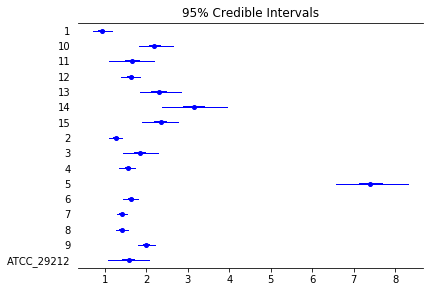

In [12]:
pm.forestplot(trace, varnames=['fold'], ylabels=le.classes_)